<a href="https://colab.research.google.com/github/james-monahan/Code-school-notebooks/blob/main/Week-9-ml-regression/ML_challenge_Regressions_Weather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Execute the code below

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import pandas as pd
import numpy as np
link_main = "https://raw.githubusercontent.com/murpi/wilddata/master/quests/weather_main_2018.csv"
link_opinion = "https://raw.githubusercontent.com/murpi/wilddata/master/quests/weather_opinion_2018.csv"
df_main = pd.read_csv(link_main)
df_opinion = pd.read_csv(link_opinion)
print(df_main.head())
print(df_opinion.head())

         DATE  MAX_TEMPERATURE_C  ...  DEWPOINT_MAX_C  WINDTEMP_MAX_C
0  2018-01-01                 12  ...               8               7
1  2018-01-02                 13  ...              12               6
2  2018-01-03                 15  ...              13               7
3  2018-01-04                 14  ...              12              10
4  2018-01-05                 12  ...              10               7

[5 rows x 15 columns]
         date  WEATHER_CODE_EVENING  TOTAL_SNOW_MM  UV_INDEX  SUNHOUR OPINION
0  2018-01-01                   113              0         3      5.1     bad
1  2018-03-12                   119              0         2      8.8     bad
2  2018-03-09                   116              0         3     10.2     bad
3  2018-10-07                   122              0         1      5.6     bad
4  2018-06-18                   119              0         1     12.9     bad


In [ ]:
def merge_and_fill(DataFrameMain, DataFrameOpinion):
  NewDataFrame = pd.merge(DataFrameMain, DataFrameOpinion, how='left', left_on='DATE', right_on='date')
  NewDataFrame.drop('date', axis=1, inplace=True)
  mean_weather_column = NewDataFrame['WEATHER_CODE_EVENING'].median()
  NewDataFrame['WEATHER_CODE_EVENING'].fillna(mean_weather_column, inplace = True) 
  NewDataFrame['TOTAL_SNOW_MM'].fillna(0, inplace = True)
  NewDataFrame['UV_INDEX'] = NewDataFrame.groupby(NewDataFrame.DATE.astype('datetime64').dt.month)['UV_INDEX'].apply(lambda x: x.fillna(x.median()))
  NewDataFrame['OPINION'].fillna('unknown', inplace = True)
  return NewDataFrame

# Merge
First of all, you have to merge both DataFrames to have a bien "df2018" DataFrame with 365 rows and 20 columns (indeed, you can drop the date column in double).



In [ ]:
df_weather = merge_and_fill(df_main, df_opinion)
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365 entries, 0 to 364
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   DATE                    365 non-null    object 
 1   MAX_TEMPERATURE_C       365 non-null    int64  
 2   MIN_TEMPERATURE_C       365 non-null    int64  
 3   WINDSPEED_MAX_KMH       365 non-null    int64  
 4   TEMPERATURE_MORNING_C   365 non-null    int64  
 5   TEMPERATURE_NOON_C      365 non-null    int64  
 6   TEMPERATURE_EVENING_C   365 non-null    int64  
 7   PRECIP_TOTAL_DAY_MM     365 non-null    float64
 8   HUMIDITY_MAX_PERCENT    365 non-null    int64  
 9   VISIBILITY_AVG_KM       365 non-null    float64
 10  PRESSURE_MAX_MB         365 non-null    int64  
 11  CLOUDCOVER_AVG_PERCENT  365 non-null    float64
 12  HEATINDEX_MAX_C         365 non-null    int64  
 13  DEWPOINT_MAX_C          365 non-null    int64  
 14  WINDTEMP_MAX_C          365 non-null    in

# Linear regresssion
There are some missing values in the "Sunhour" column, and you want to fill them.

First, you have to split the DataFrame to have :
- a DF with only rows without NaN, you'll call it "df_clean". This DF should have 341 rows and 20 columns.
- a DF with only rows with NaN in the Sunhour column (The rows you want to fill), you'll call it "df_nan". This DF should have 24 rows and 20 columns.


In [ ]:
na_mask = df_weather['SUNHOUR'].isna()
df_weather_na = df_weather.loc[na_mask]
df_weather_clean = df_weather.loc[~na_mask]
print(df_weather_na.shape, df_weather_vals.shape)

(24, 20) (341, 20)


## Now, train your model
For this part, let's work on df_clean. 
With scikit-learn, find the multivariate linear regression model with the best score (remember to train-test-split your DataFrame "df_clean" before!). 

You are trying to predict `SUNHOUR`, so what's your target `y` ?

Print the R2-score for the test set, and check if you don't have underfitting or overfitting.

In [ ]:
X = df_weather_clean.select_dtypes(['int64', 'float64']).drop('SUNHOUR', axis=1)
y = df_weather_clean['SUNHOUR']

weather_model = LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

weather_model.fit(X_train, y_train)

print("train score:",weather_model.score(X_train, y_train))
print("test score:",weather_model.score(X_test, y_test))

train score: 0.749196868461679
test score: 0.6834247267984628


## Predictions
Predict the sunhours values for your DF "df_nan", and store result in the `SUNHOUR` column (which is empty, because this is `df_nan`).

In [ ]:
X_pred = df_weather_na.select_dtypes(['int64', 'float64']).drop('SUNHOUR', axis=1)
df_weather_na = df_weather.loc[na_mask]
sunhour_preds = weather_model.predict(X_pred)
df_weather_na.loc[:,'SUNHOUR'] = sunhour_preds

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


## Concatenate and scatterplot

Concatenate both DataFrames to a new one "df2018complete", and draw a scatterplot with Date on X-axis and Sunhours on Y-axis.
Try to add a flag to identify real values and predicted values. 

You should get something like that. Of course, not exactly the same chart, because we don't train the same model, on came columns, etc...

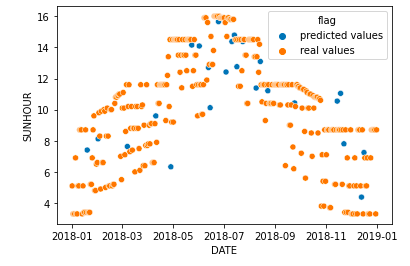

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


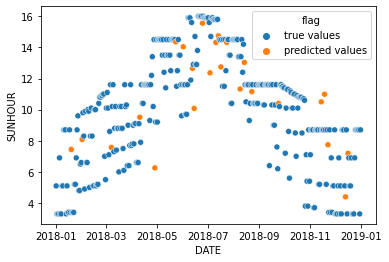

In [ ]:
date_dt = df2018complete['DATE'].astype('datetime64')
df_weather_na['flag'] = 'predicted values'
df_weather_clean['flag'] = 'true values'
df2018complete = pd.concat([df_weather_na, df_weather_clean], axis=0).sort_values('DATE')
sns.scatterplot(data= df2018complete, x=date_dt, y='SUNHOUR', hue='flag')
plt.show()